<div style="display: flex; gap: 10px;">
  <img src="../images/HOOPS_AI.jpg" style="width: 20%;">

# CAD Similary Search using HOOPS EMBEDDINGS

This guide demonstrates how to embed CAD files, index them for similarity search, and retrieve similar parts using the HOOPS AI embeddings API.

## Overview

The `HOOPSEmbeddings` API provides production-ready tools for:

- **Computing embeddings** from CAD files (single or batch)
- **Vector database connectors** (FAISS, with Qdrant/Weaviate/Pinecone support planned)
- **Similarity search** and retrieval in optimized vector spaces
- **Pre-trained models** ready to use out-of-the-box
- **Custom model support** via model registration

In [1]:
import hoops_ai
import os

hoops_ai.set_license(hoops_ai.use_test_license(), validate=False)

ℹ️ Using TEST LICENSE (expires February 8th, 2026 - 8 days remaining)
   For production use, obtain your own license from Tech Soft 3D
HOOPS AI version :  1.0.0-b2dev13 



### Production Workflow (3 Steps)

1. **Embed**: Convert CAD files to vector embeddings using `HOOPSEmbeddings`
2. **Index**: Store embeddings in a vector store using `Faiss`
3. **Search**: Query for similar parts using CAD files or embeddings `CADSearch`

## Register your trained model

In [2]:
import pathlib

nb_dir = pathlib.Path.cwd()
test_files = nb_dir.parent.joinpath("packages")
trained_model = nb_dir.parent.joinpath("packages", "trained_ml_models", "ts3d_1M_hoops_embeddings.ckpt")

In [3]:
from hoops_ai.ml.embeddings import HOOPSEmbeddings, Embedding, EmbeddingBatch

# Register your custom model (trained using EmbeddingFlowModel)
HOOPSEmbeddings.register_model(
    model_name="my_embeddings_flow_model",
    checkpoint_path=str(trained_model)
)

print(HOOPSEmbeddings.list_available_models())

['my_embeddings_flow_model']


## Instantiate the `HOOPSEmbedings` to generate the cad embeddings from that trained model 

In [4]:

embedder = HOOPSEmbeddings(model="my_embeddings_flow_model")

print(f"Using model: {embedder.model_name} with dimension: {embedder.embedding_dim}")

Successfully loaded model from checkpoint: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\packages\trained_ml_models\ts3d_1M_hoops_embeddings.ckpt
Using model: my_embeddings_flow_model with dimension: 2048


## Compute the embeddings for a list of cad files

### get the cad list

In [5]:
from hoops_ai.storage import CADFileRetriever, LocalStorageProvider
cad_sources = test_files.joinpath("cadfiles","fabwave")

retriever = CADFileRetriever(storage_provider=LocalStorageProvider(directory_path=cad_sources), formats=[".stp", ".step", ".iges", ".igs"])
            
# Get files using the library's retriever
cad_files = retriever.get_file_list()
print(len(cad_files), "files found." )

4572 files found.


### Create an Embedding batch

In [6]:
embeddingBatch = embedder.embed_shape_batch(cad_files, num_workers=20, show_progress=True)

# Inspect results
print(f"Successfully embedded: {len(embeddingBatch.ids)} files")
print(f"Embedding matrix shape: {embeddingBatch.values.shape}")  # (n_files, dim)
print(f"Failed: {embeddingBatch.metadata['failed_count']}")
print(f"Model used: {embeddingBatch.model}")

Computing embeddings:   0%|                                                                   | 0/4572 [00:00<…

| TASK | Undefined flowdir to write corrupted file summary. Using path [.]
| TASK | Total number of items with errors: 26 (0.57%)
| TASK | Corrupted items are listed in 'error_summary.json'.
Successfully embedded: 4546 files
Embedding matrix shape: (4546, 2048)
Failed: 26
Model used: CUSTOM:my_embeddings_flow_model


### Index Embeddings for Search

Once you have an `EmbeddingBatch`, index it using `CADSearch`:

In [7]:
from hoops_ai.ml import CADSearch

emb_searcher = CADSearch(shape_model=embedder)


emb_searcher.index_shape(embeddingBatch)

Indexed 4546 shape embeddings (dim=2048)


**What happens during indexing:**
- Embeddings are stored in a FAISS vector store (default)
- Part IDs from the batch are mapped to vectors
- Metadata is cached for quick retrieval

## Persisting Indices for Reuse

When working with large datasets, re-computing embeddings and re-indexing can be time-consuming. The persistence API allows you to save computed indices to disk and reload them in future sessions.

### Saving an Index

After indexing embeddings, save the vector store to disk:

In [8]:
emb_searcher.save_shape_index("fabwave_embeddings_store.faiss")

### Loading a Saved Index

In a new session, skip indexing and load directly:

In this example, we will load this store that contains about 5 thousands files with mechanical parts.
Notice we initialize a new CADSearch object.

In [9]:
loaded_searcher = CADSearch(shape_model=embedder)

indexed_database = pathlib.Path.cwd().joinpath("fabwave_embeddings_store.faiss") #test_files.joinpath("vectorstores","fabwave_embeddings_store.faiss")

loaded_searcher.load_shape_index(path=str(indexed_database))

In [10]:
from hoops_ai.insights import DatasetViewer

ds_viewer = DatasetViewer([], [], [], reference_dir=pathlib.Path.cwd().joinpath("out"))

2026-01-30 10:13:51 | INFO | hoops_ai.insights.dataset_viewer | Initialized process pool with 4 workers
2026-01-30 10:13:51 | INFO | hoops_ai.insights.dataset_viewer | DatasetViewer initialized with reference directory: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out
2026-01-30 10:13:51 | INFO | hoops_ai.insights.dataset_viewer | Built file mapping for 0 files


**Key Points:**
- **No re-indexing**: Skip embedding computation entirely
- **Faster startup**: Load index in seconds vs. minutes/hours
- **Portable**: Share index files with team members
- ⚠️ **Model consistency**: Ensure the same `HOOPS EMBEDDINGS model` is used for loading and querying

## Search for Similar Parts

### Search by CAD File (Query-Time Embedding)

Search using a new CAD file - the model will embed it on-the-fly:

2026-01-30 10:13:57 | INFO | hoops_ai.insights.dataset_viewer | Generating 12 PNGs using persistent process pool...
2026-01-30 10:14:25 | INFO | hoops_ai.insights.dataset_viewer | PNG generation complete. 12/12 successful


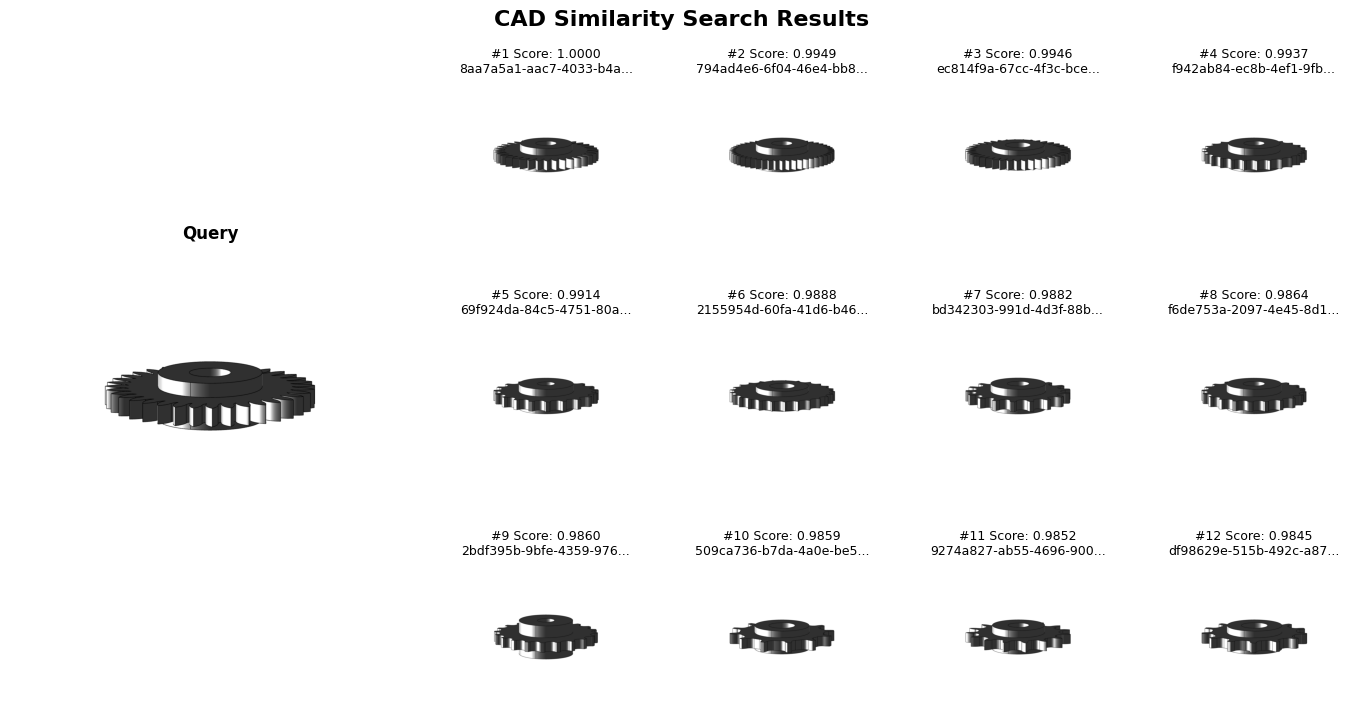

In [11]:
query = str(test_files.joinpath("cadfiles","idler_sprocket.step"))
hits = loaded_searcher.search_by_shape(query, top_k=12)

ds_viewer.show_search_results(hits, query_file=query, grid_cols=4)

**How it works:**
1. Query CAD file is embedded using the specific `HOOPSEmbeddings model`
2. Vector store computes similarity against indexed embeddings
3. Returns top-k most similar parts with scores
4. The dataset Viewer, generated on the fly images from the cad files path in the meta data of the vector store

2026-01-30 10:14:37 | INFO | hoops_ai.insights.dataset_viewer | Generating 12 PNGs using persistent process pool...
2026-01-30 10:14:56 | INFO | hoops_ai.insights.dataset_viewer | PNG generation complete. 12/12 successful


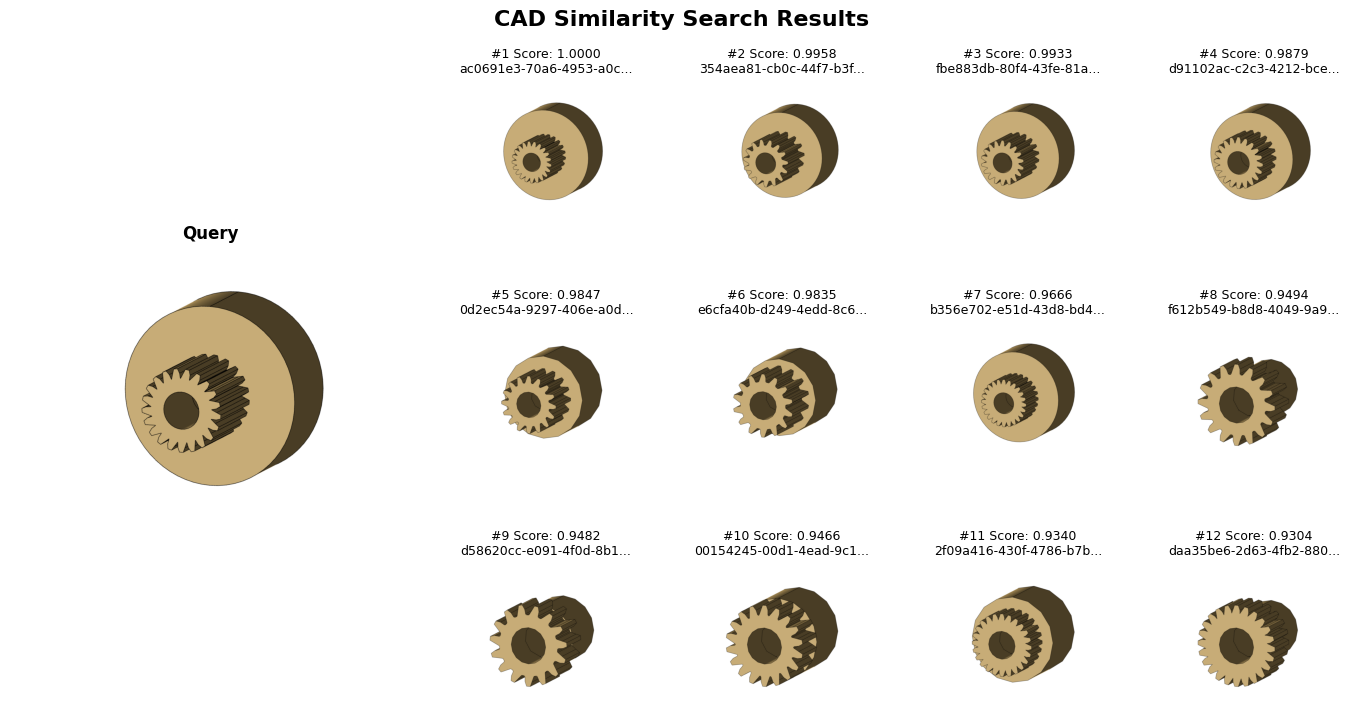

In [12]:
query = str(test_files.joinpath("cadfiles","gear_fabwave.step"))
hits = loaded_searcher.search_by_shape(query, top_k=12)

ds_viewer.show_search_results(hits, query_file=query, grid_cols=4)

2026-01-30 10:15:06 | INFO | hoops_ai.insights.dataset_viewer | Generating 12 PNGs using persistent process pool...
2026-01-30 10:15:27 | INFO | hoops_ai.insights.dataset_viewer | PNG generation complete. 12/12 successful


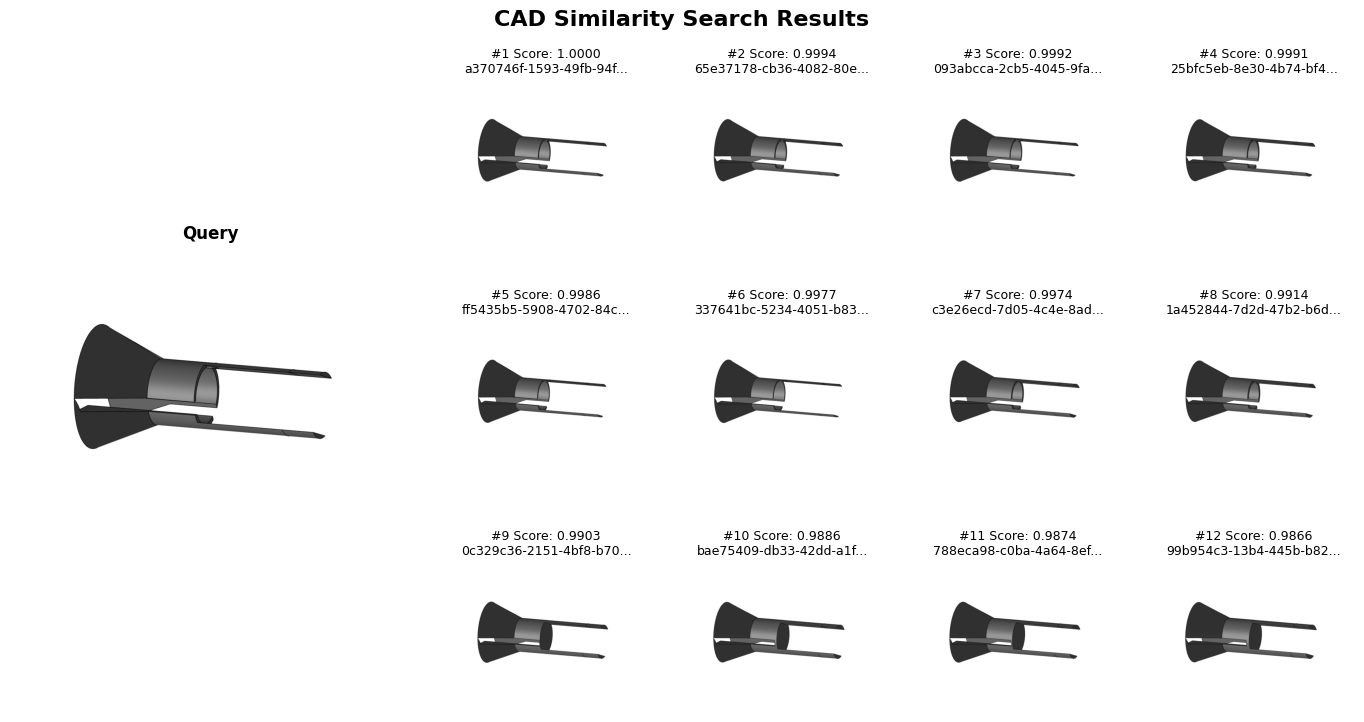

In [13]:
query = str(test_files.joinpath("cadfiles","collets_fabwave.step"))
hits = loaded_searcher.search_by_shape(query, top_k=12)

ds_viewer.show_search_results(hits, query_file=query, grid_cols=4)

2026-01-30 10:15:46 | INFO | hoops_ai.insights.dataset_viewer | Generating 12 PNGs using persistent process pool...
2026-01-30 10:16:16 | INFO | hoops_ai.insights.dataset_viewer | PNG generation complete. 12/12 successful


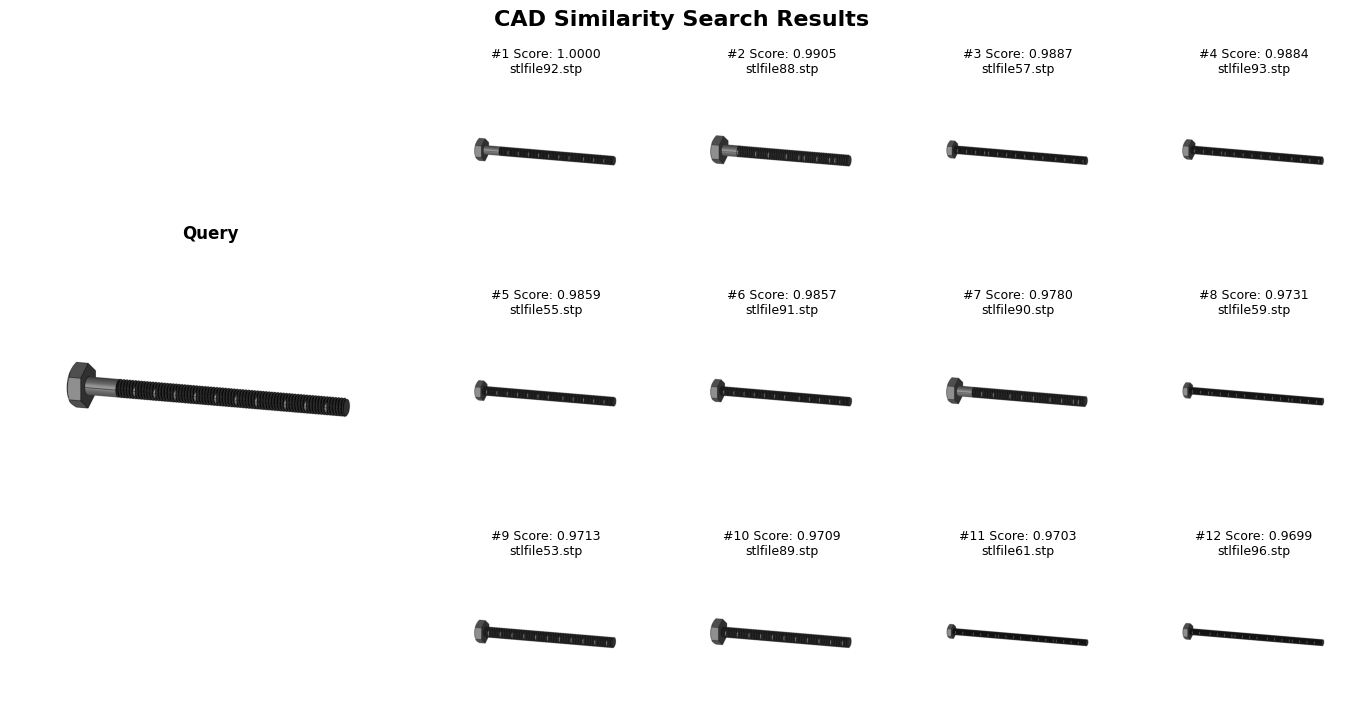

In [14]:
query = str(test_files.joinpath("cadfiles","hex_head_screws_fabwave.step"))
hits = loaded_searcher.search_by_shape(query, top_k=12)

ds_viewer.show_search_results(hits, query_file=query, grid_cols=4)